In [1]:
%matplotlib inline
%run ./FImport.py
%load_ext autoreload

from FLib import *
from matplotlib.gridspec import GridSpec
from multiprocessing import Pool

MAX_CN = 2_000
MIN_CN = 0.1

In [2]:
def getSS5(par, cNMod):
    b0, a, gamma, eps = par.b0, par.a, par.gamma, par.eps
    return (cNMod, (b0-1-b0*cNMod) / (b0*(cNMod-1)*(a-1)))

def getSS5Path(sol,  cNsMin=None, cNsMax=None):
    if cNsMin is None: cNsMin = min(sol.par.cN-sol.par.u0, sol.par.cN-sol.par.u1)
    if cNsMax is None: cNsMax = max(sol.par.cN-sol.par.u0, sol.par.cN-sol.par.u1)
    cNs = np.logspace(*np.log10([cNsMin, cNsMax]), 200)
    SS5s = np.array([getSS5(sol.par, cN) for cN in cNs])
    return SS5s, cNs

def plotSSAndStart(ax, sol, cNsMin=None, cNsMax=None):
    ss5,_ = getSS5Path(sol, cNsMin, cNsMax)
    ax.scatter(*sol.par.x0, c="black", zorder=10)
    ax.plot(ss5[:,0],ss5[:,1], c="black", alpha=0.5, zorder=-1) 

def plotTraj(ax, sols, colors):
    for sol,c in zip(sols, colors):
        ax.scatter(*sol.par.x1, c=[c])
        ax.plot(sol.evol.x[:, 0], sol.evol.x[:, 1], c=c)
              
def plotFree(ax, sols, colors):
    for sol,c in zip(sols, colors):
        ax.scatter(*sol.par.x1, c=[c])
        ax.plot(sol.evolFree.x[:, 0], sol.evolFree.x[:, 1], c=c)

def plotControl(ax, sol, xlim=None, color="C0"):
    if xlim is None: xlim = (sol.evol.t.min(), sol.evol.t.max())
    deltaT = sol.evol.t.max() - sol.evol.t.min()
    
    if xlim[0]==sol.evol.t.min():
        tBefore = np.arange(-deltaT*0.1, 0)
        ax.plot(tBefore, [sol.par.u0]*len(tBefore), "--", c="gray")
    
    if xlim[1]==sol.evol.t.max():
        tAfter = np.arange(xlim[1], xlim[1]+deltaT*0.1)
        ax.plot(tAfter, [sol.par.u1]*len(tAfter), "--", c="gray")

    ax.plot(sol.evol.t, sol.par.u1 + sol.evol.u[:, 0])
        
    ax.set_xlabel(r"$t$")
    ax.set_ylabel(r"$u$")

In [3]:
from dataclasses import dataclass

@dataclass()
class parameters():
    h0: float = 0.5
    h1: float = 0.9
    boundOverPolicy: float = 0.3
    boundUnderPolicy: float = 0.3

    b0: float = 5
    a: float = .2
    gamma: float = 1
    eps: float = 1
    cN: float = 0.75
    
    weightAtX1: float = 1e4
    
    def __post_init__(self):
        self.u0 = self.cN * self.h0
        self.u1 = self.cN * self.h1 
        self.x0 = np.array(self.getSS(self.u0))
        self.x1 = np.array(self.getSS(self.u1))
        
        if self.u1>self.u0: 
            self.uUBound = self.u1 + abs(self.u1-self.u0)*self.boundOverPolicy
            self.uLBound = self.u0 - abs(self.u1-self.u0)*self.boundUnderPolicy
        else: 
            self.uUBound = self.u0 + abs(self.u1-self.u0)*self.boundUnderPolicy
            self.uLBound = self.u1 - abs(self.u1-self.u0)*self.boundOverPolicy
                
    def getSS(self, u):
        b0, a, gamma, eps, cN = self.b0, self.a, self.gamma, self.eps, self.cN
        c = cN - u 
        
        ## x1
        if b0 < 1: 
            return [0, 0] 
        ## x3
        if (c>(1-1/b0) or c>=1) and b0 > 1: 
            return [1 - 1/b0, zero] 
        ## x4
        if c<(b0*a - 1)/(b0*a): 
            return [1 - 1/(b0*a), 1] 
        ## x5
        if b0>1 and b0<=1/a and c<(b0-1)/b0:
            return [c, (b0 - 1 - b0*c)/(b0*(c-1)*(a-1))]
        if b0>1/a and c<(b0-1)/b0 and c<(b0*a-1)/b0*a:
            return [c, (b0 - 1 - b0*c)/(b0*(c-1)*(a-1))]

In [4]:
class solver():
    def __init__(self, par, eps=.001, nStep=1000, t1=15.0, weightAtX1=1000, verbose=1, tol=0.01):
        self.par = par 
        
        self.nStep = nStep
        self.tol = tol
        
        self.weightAtX1 = weightAtX1
        self.verbose = verbose
        self.t1=t1
        
        self.evol = dataEvol(np.linspace(0, t1, nStep))
        self.evolFree = dataEvol(np.linspace(0, t1, nStep))
        self.evolInitGuess = dataEvol(np.linspace(0, t1, nStep))
        
        self.rhsState = partial(rhsState, par=par)
        self.rhsLambda = partial(rhsLambda, par=par)
        self.optControl = partial(optControl, par=par)
        self.boundaryCondition = partial(boundaryCondition, par=par)
        
    def freeRun(self, tol=1e-3):
        f = partial(rhsStateWithFixedControl, interpolateU=self.evolFree.getContinousU(), par=self.par)
        sol = odeint(f, self.par.x0, self.evolFree.t)
        self.evolFree.x = sol
        
    def setInitialGuess(self):
        self.evolInitGuess = copy(self.evolFree)
        
        
    def rhsAll(self, t, X):
        x = X[[0, 1]]
        lamb = X[[2,3]]
        
        uStar = self.optControl(x, lamb)
        lambDot = self.rhsLambda(x, uStar, lamb) 
        xDot = self.rhsState(x, uStar)
        
        return np.vstack([xDot, lambDot])
    
           
    def solve(self):
        t = self.evolInitGuess.t
        X = np.hstack([self.evolInitGuess.x, self.evolInitGuess.lamb]).transpose()
        
        res = solve_bvp(self.rhsAll, self.boundaryCondition, t, X, max_nodes=1_000_000, tol=self.tol, verbose=self.verbose)
        X = res.sol(t)
        
        self.evol.x = X[[0, 1]].transpose()
        self.evol.lamb = X[[2,3]].transpose()
        self.evol.u = self.optControl(X[[0, 1]], X[[2,3]]).transpose()
        #initGuess.x = self.solveState(initGuess.t, initGuess.u, initGuess.x[0])
        
        self.success = res.success

# Cost Original

In [10]:
def rhsState(x_k, u_k, par):
    b0, a, gamma, eps, cN = par.b0, par.a, par.gamma, par.eps, par.cN
    h0, h1, u0, u1 = par.h0, par.h1, par.u0, par.u1
    I, P, ut = x_k[0], x_k[1], u_k[0]

    alpha = I - (cN - u1 - ut)
    beta = b0*((1-P) + a*P)

    rhsI = beta*I*(1-I) - gamma*I
    rhsP = eps*P*(1-P) * alpha
    
    return np.array([rhsI, rhsP])

    
def rhsLambda(x_k, u_k, lamb_k, par):
    b0, a, gamma, eps, cN = par.b0, par.a, par.gamma, par.eps, par.cN
    h0, h1, u0, u1 = par.h0, par.h1, par.u0, par.u1
    JF, PF = par.x1[0], par.x1[1]
    
    I, P, ut = x_k[0], x_k[1], u_k[0]            
    lamb1, lamb2 = lamb_k[0], lamb_k[1]

    J,u = I,u1
    alpha = a
    h = h1
    
    rhsILamb1 = - (2*h*J + (-1-b0*(-1+2*J)*(1+P*(-1+alpha)))*lamb1 - (-1+P)*P*eps*lamb2)
    rhsILamb2 = - (-b0*(-1+J)*J*(-1+alpha)*lamb1 - (-1+2*P)*(-cN+J+u+ut)*eps*lamb2)
   
    return np.array([rhsILamb1, rhsILamb2])


def optControl(x_k, lamb_k, par):
    b0, a, gamma, eps, cN = par.b0, par.a, par.gamma, par.eps, par.cN
    h0, h1, u0, u1 = par.h0, par.h1, par.u0, par.u1
    I, P = x_k[0], x_k[1]      
    lamb1, lamb2 = lamb_k[0], lamb_k[1]
        
    u_star = -u1 - ((-1+P)*P*eps*lamb2)/(2*(-1+h1))

    u_star = np.minimum(par.uUBound-u1, u_star)
    u_star = np.maximum(par.uLBound-u1, u_star)
    return np.array([u_star,])


def rhsStateWithFixedControl(x_k, t, interpolateU, par):
    u_k = interpolateU(t)
    return rhsState(x_k, u_k, par)


def boundaryCondition(xa, xb, par):
    termValLamb0 = xb[0] - par.x1[0]
    termValLamb1 = xb[1] - par.x1[1]
    termValLamb0 *= par.weightAtX1
    termValLamb1 *= par.weightAtX1

    return np.array([xa[0]-par.x0[0], xa[1]-par.x0[1], xb[2]-termValLamb0, xb[3]-termValLamb1])

In [311]:
par = parameters(
    h1 = 0.996079,
    h0 = 0.995643,
    b0 = 1.77328,
    a = 0.13,
    cN = 0.436074,
    boundOverPolicy=.5,
    boundUnderPolicy=.5,
    weightAtX1 = 1000,
    eps=0.97
)
sol = solver(par, t1=66.8, nStep=1000, tol=1e-5)
sol.freeRun()
sol.setInitialGuess()
sol.solve()

Solved in 5 iterations, number of nodes 10952. 
Maximum relative residual: 1.95e-07 
Maximum boundary residual: 5.19e-14


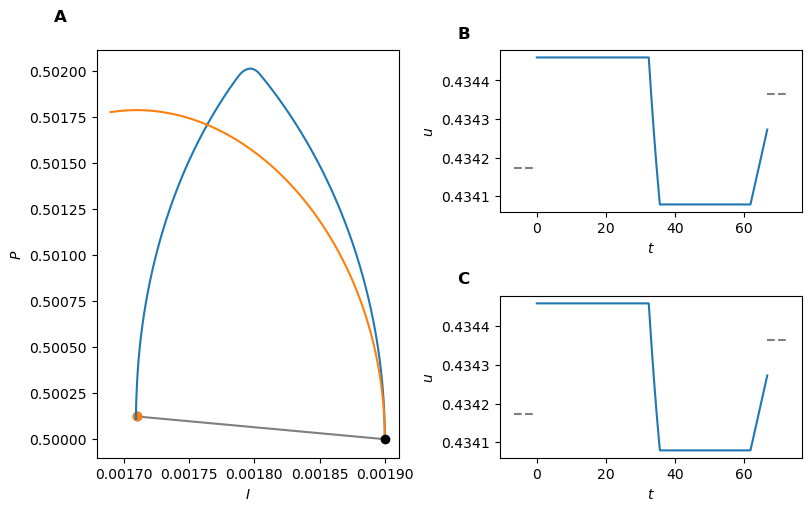

In [312]:
fig = plt.figure(figsize=(8,5), constrained_layout=True)
gs = GridSpec(2, 4, figure=fig)
ax1, ax2, ax3 = fig.add_subplot(gs[0:2, 0:2]), fig.add_subplot(gs[0, 2:4]), fig.add_subplot(gs[1, 2:4])

plotSSAndStart(ax1, sol)
plotTraj(ax1, [sol], ["C0"])
plotFree(ax1, [sol], ["C1"])
ax1.set_xlabel(r"$I$")
ax1.set_ylabel(r"$P$")

plotControl(ax2, sol)
plotControl(ax3, sol)

betterPanelLabel([ax1], offset=[0., -0.05])
betterPanelLabel([ax2,ax3], startingLetter=1, offset=[-.0, .0])

# Optimal Times

In [13]:
def solveOne(sol):
    sol.freeRun()
    sol.setInitialGuess()
    sol.solve()
    return sol 

def solveGrid(par, tMin, tMax, step=50):
    ts = np.linspace(tMin, tMax, step)
    sols = [solver(par, t1=t1, nStep=500, tol=1e-3, verbose=0) for t1 in ts]
    
    with Pool(20) as pool:
        sols = pool.map(solveOne, sols)
    
    dists = [np.linalg.norm(sol.evol.x[-1] - sol.par.x1) for sol in sols]
    distInter = interp1d(ts, dists, fill_value="extrapolate", axis=0, kind="quadratic")
    #distInter = interp1d(ts, dists, fill_value="extrapolate", axis=0, kind="linear")

    _t = np.linspace(ts.min(), ts.max(), 200)
    _dists = distInter(_t)

    return _t, _dists, sols

In [100]:
parBase = parameters(
    h1 = 0.996079,
    h0 = 0.995643,
    b0 = 1.77328,
    a = 0.13,
    cN = 0.436074,
    boundOverPolicy=.5,
    boundUnderPolicy=.5,
    weightAtX1 = 5000,
    eps=1)

In [101]:
parsDw = [copy(parBase),copy(parBase),copy(parBase)]
parsDw[0].h1 = 0.995207
parsDw[1].h1 = 0.994772
parsDw[2].h1 = 0.993464
[i.__post_init__() for i in parsDw];

parsUp = [copy(parBase),copy(parBase),copy(parBase)]
parsUp[0].h1 = 0.996079
parsUp[1].h1 = 0.996514
parsUp[2].h1 = 0.997821
[i.__post_init__() for i in parsUp];

In [102]:
#[59.5, 58.8, 56.0]
ranges = [(57,61), (57,60), (55,57)]
gridDw = [solveGrid(i, r[0], r[1], 10) for i,r in zip(parsDw,ranges)]

#[63.6, 65.5, 73.5]
#ranges = [(60,66), (64,67), (70,74)]
#gridUp = [solveGrid(i, r[0], r[1], 10) for i,r in zip(parsUp,ranges)]

59.5929648241206
58.85427135678392
55.80904522613066


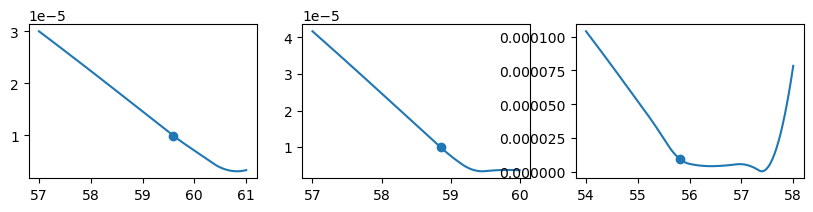

In [114]:
fig, axs = plt.subplots(1,3, figsize=(10, 2))

for ax, data in zip(axs,gridDw):
    _t, _dists, _ = data
    ax.plot(_t, _dists)
    arg = np.where(_dists<1e-5)[0].min()
    ax.scatter(_t[arg], _dists[arg])
    print(_t[arg])

62.53266331658291
65.0251256281407
73.05527638190955


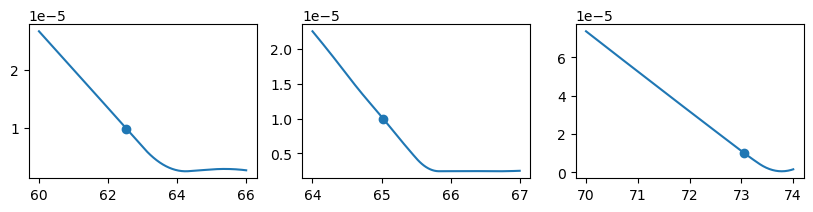

In [117]:
fig, axs = plt.subplots(1,3, figsize=(10, 2))

for ax, data in zip(axs,gridUp):
    _t, _dists, _ = data
    ax.plot(_t, _dists)
    arg = np.where(_dists<1e-5)[0].min()
    ax.scatter(_t[arg], _dists[arg])
    print(_t[arg])

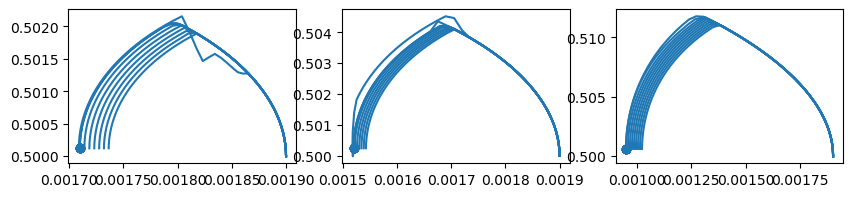

In [87]:
fig, axs = plt.subplots(1,3, figsize=(10, 2))

_,_,solsUp = gridUp[0]
plotTraj(axs[0], solsUp, ["C0"]*len(solsUp)) 
_,_,solsUp = gridUp[1]
plotTraj(axs[1], solsUp, ["C0"]*len(solsUp)) 
_,_,solsUp = gridUp[2]
plotTraj(axs[2], solsUp, ["C0"]*len(solsUp)) 

# Run on optimal time

In [14]:
palette_tab10 = sns.color_palette("RdYlBu", 8)
palette_tab10 = sns.color_palette("Spectral", 8)
colors1 = sns.color_palette([palette_tab10[0], palette_tab10[1], palette_tab10[2]])
colors2 = sns.color_palette([palette_tab10[-1], palette_tab10[-2], palette_tab10[-3]])

In [15]:
parBase = parameters(
    h1 = 0.996079,
    h0 = 0.995643,
    b0 = 1.77328,
    a = 0.13,
    cN = 0.436074,
    boundOverPolicy=.5,
    boundUnderPolicy=.5,
    weightAtX1 = 5000,
    eps=1)

In [16]:
parsDw = [copy(parBase),copy(parBase),copy(parBase)]
parsDw[0].h1 = 0.995207
parsDw[1].h1 = 0.994772
parsDw[2].h1 = 0.993464
[i.__post_init__() for i in parsDw];

parsUp = [copy(parBase),copy(parBase),copy(parBase)]
parsUp[0].h1 = 0.996079
parsUp[1].h1 = 0.996514
parsUp[2].h1 = 0.997821
[i.__post_init__() for i in parsUp];

In [17]:
def _plotControl(ax, sol, c, before=0.2, normalized=False, normalizedT=False):
    t = sol.evol.t
    t = np.r_[0, t, t.max()]
    
    u = sol.par.u1 + sol.evol.u[:, 0]
    u = np.r_[[sol.par.u0], u, [sol.par.u1]]
  
    ax.plot(t[0:], u[0:], alpha=1.0, c=c)
    
    tAfter = np.arange(t.max(), 100)
    ax.plot(tAfter, [sol.par.u1]*len(tAfter), "--", c="gray")
    
    
def plotControl(ax, sols, colors):
    # before
    tBefore = np.arange(-10, 0.1)
    ax.plot(tBefore, [sols[0].par.u0]*len(tBefore), "--", c="gray")


    for i,c in zip(sols, colors): _plotControl(ax, i, c)
        
    ax.set_xlabel(r"$t$")
    ax.set_ylabel(r"$u$")
    
    ax.set_xlim(-10, 90)

In [18]:
optTimeUp = [
    62.43266331658291,
    65.0251256281407,
    73.05527638190955]

solsUp = [solver(par, t1=t1, nStep=50, tol=1e-3) for par,t1 in zip(parsUp,optTimeUp)]
[solveOne(sol) for sol in solsUp];

Solved in 8 iterations, number of nodes 5786. 
Maximum relative residual: 4.56e-04 
Maximum boundary residual: 7.95e-14
Solved in 8 iterations, number of nodes 4972. 
Maximum relative residual: 3.62e-05 
Maximum boundary residual: 7.39e-14
Solved in 8 iterations, number of nodes 22813. 
Maximum relative residual: 3.40e-05 
Maximum boundary residual: 1.50e-13


In [19]:
optTimeDw = [
    59.5929648241206,
    58.85427135678392,
    55.80904522613066]

solsDw = [solver(par, t1=t1, nStep=500, tol=1e-3) for par,t1 in zip(parsDw,optTimeDw)]
[solveOne(sol) for sol in solsDw];

Solved in 6 iterations, number of nodes 14211. 
Maximum relative residual: 6.44e-05 
Maximum boundary residual: 9.41e-14
Solved in 6 iterations, number of nodes 20831. 
Maximum relative residual: 5.62e-07 
Maximum boundary residual: 7.48e-14
Solved in 5 iterations, number of nodes 16639. 
Maximum relative residual: 4.94e-06 
Maximum boundary residual: 2.06e-14


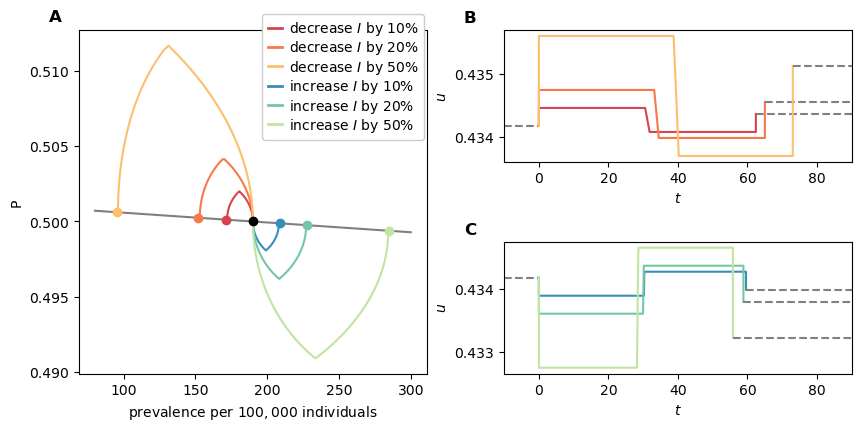

In [59]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(8.5,4.2), constrained_layout=True)
gs = GridSpec(2, 4, figure=fig)
ax1 = fig.add_subplot(gs[0:2, 0:2])
ax2 = fig.add_subplot(gs[0, 2:4])
ax3 = fig.add_subplot(gs[1, 2:4])

plotSSAndStart(ax1, solsUp[0], cNsMin=0.003, cNsMax=0.0008)
plotTraj(ax1, solsUp, colors1)
plotTraj(ax1, solsDw, colors2)
plotControl(ax2, solsUp, colors1)
plotControl(ax3, solsDw, colors2)


label = [fr"decrease $I$ by ${i}\%$" for i in [10, 20, 50]]
for c,l in zip(colors1,label): ax1.plot(0,0 , label=l, transform=ax1.transAxes, color=c)
label = [fr"increase $I$ by ${i}\%$" for i in [10, 20, 50]]
for c,l in zip(colors2,label): ax1.plot(0,0 , label=l, transform=ax1.transAxes, color=c)
legend = ax1.legend(bbox_to_anchor=(0.76,0.66,0,1), loc=8, ncol = 1, handlelength=1, handletextpad=0.5, labelspacing=.1)
legend.get_frame().set_facecolor((1,1,1,1))
legend.get_frame().set_alpha(None)
for line in legend.get_lines(): line.set_linewidth(2.0)

ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*100_000))
ax1.xaxis.set_major_formatter(ticks)
ax1.set_xlabel(r"prevalence per $100,000$ individuals")
ax1.set_ylabel("P")

betterPanelLabel([ax1], offset=[0.05, -0.09])
betterPanelLabel([ax2,ax3], startingLetter=1, offset=[.02, .0])
plt.savefig("./fig/STIUpDw.pdf",)# bbox_inches='tight')